## Part 1 ‐ Exploratory data analysis

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the JSON file
with open("logins.json", "r") as f:
    data = json.load(f)

In [3]:
# Create DataFrame
df = pd.DataFrame(data)

In [4]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
# Convert to datetime
df["login_time"] = pd.to_datetime(df["login_time"])

In [6]:
# Sort and set index
df = df.sort_values("login_time")
df = df.set_index("login_time")
df.head()

""
login_time
1970-01-01 20:12:16
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:36
1970-01-01 20:16:37


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:12:16 to 1970-04-13 18:57:38
Empty DataFrame


In [8]:
# Basic data quality checks
total_records = len(df)
start_time = df.index.min()
end_time = df.index.max()
duplicate_timestamps = df.index.duplicated().sum()
missing_values = df.isna().sum()

print("Total records:", total_records)
print("Start time:", start_time)
print("End time:", end_time)
print("Duplicate timestamps:", duplicate_timestamps)
print("Missing values:\n", missing_values)

Total records: 93142
Start time: 1970-01-01 20:12:16
End time: 1970-04-13 18:57:38
Duplicate timestamps: 877
Missing values:
 Series([], dtype: float64)


In [9]:
# Aggregate login counts into 15-minute intervals
logins_15min = df.resample("15min").size()

print(logins_15min.head())

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, dtype: int64


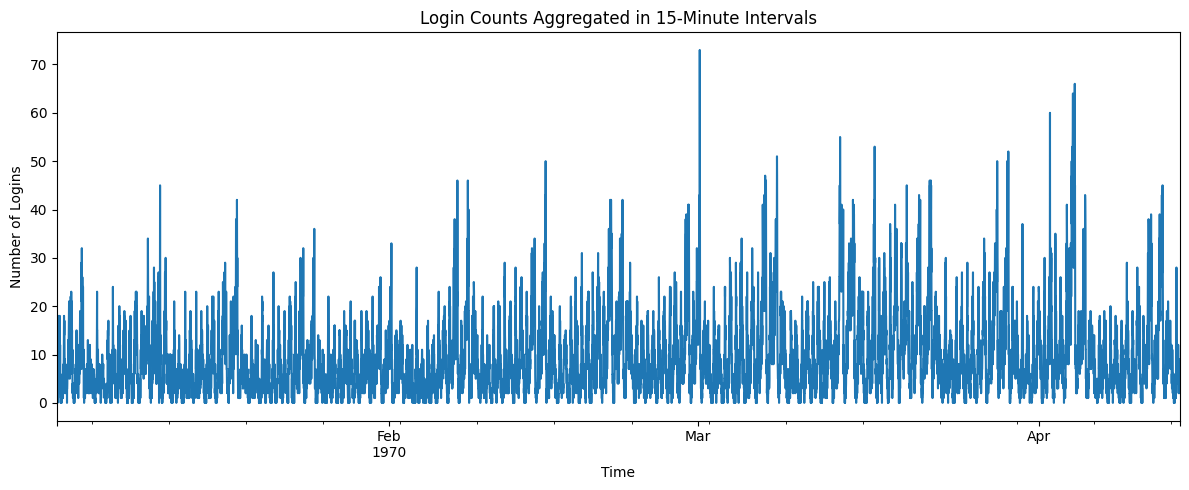

In [10]:
plt.figure(figsize=(12, 5))
logins_15min.plot()
plt.title("Login Counts Aggregated in 15-Minute Intervals")
plt.xlabel("Time")
plt.ylabel("Number of Logins")
plt.tight_layout()
plt.show()

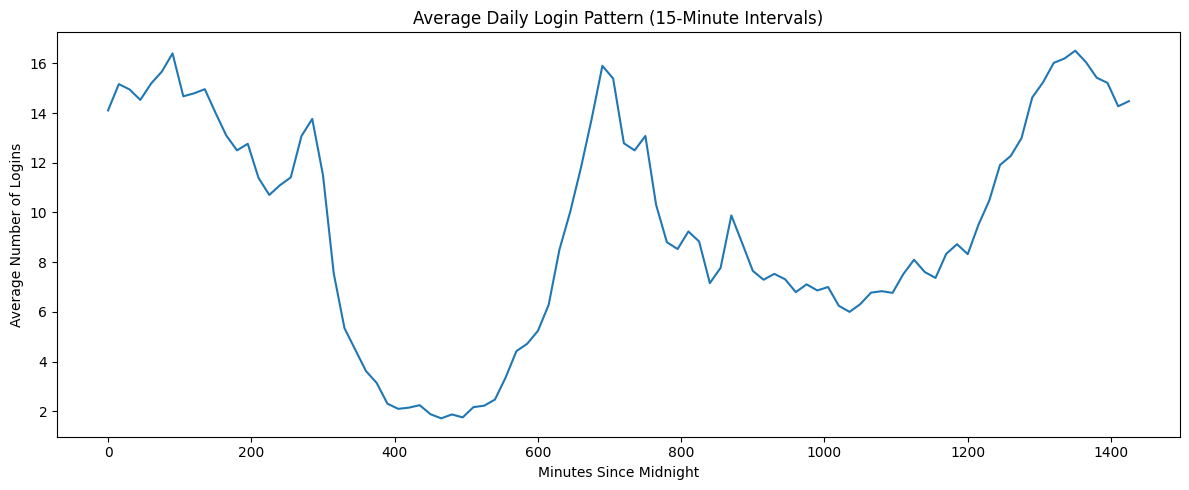

In [12]:
daily_pattern = logins_15min.groupby(logins_15min.index.time).mean()

# Convert time to minutes since midnight
x = [
    t.hour * 60 + t.minute
    for t in daily_pattern.index
]

plt.figure(figsize=(12, 5))
plt.plot(x, daily_pattern.values)
plt.title("Average Daily Login Pattern (15-Minute Intervals)")
plt.xlabel("Minutes Since Midnight")
plt.ylabel("Average Number of Logins")
plt.tight_layout()
plt.show()

Login demand shows strong daily cycles

Peaks occur during active daytime hours

Demand drops significantly overnight

Data is mostly clean with expected duplicate timestamps

15-minute aggregation effectively balances noise and pattern clarity

## Part 2 ‐ Experiment and metrics design

## Primary metric:

Percentage of active driver partners who complete trips in both Gotham and Metropolis within the same day (or week).

Why this metric:

The goal of the experiment is behavioral change: encouraging drivers to serve both cities rather than remaining exclusive.

This metric directly captures cross-city participation and is not confounded by overall demand growth.

It reflects availability alignment across complementary circadian rhythms (day vs night demand).

It is robust to short-term demand fluctuations and easy to interpret.

Supporting (secondary) metrics:

Number of cross-city trips per driver

Driver online hours split across both cities

Rider wait time during peak hours (guardrail metric)

Driver earnings per hour (to ensure no negative impact)

## a) Experiment Implementation

Design: Randomized Controlled Trial (RCT)

Population: Active driver partners operating near the Gotham–Metropolis corridor

Randomization unit: Driver partner

Control group: Drivers pay tolls as usual

Treatment group: Drivers are reimbursed for all toll bridge crossings

Duration: 3–4 weeks to capture weekday vs weekend behavior and allow habit formation

Why driver-level randomization:

Prevents spillover effects

Ensures behavioral change can be attributed to toll reimbursement

Avoids confounding due to city-level demand shifts

## b) Statistical Tests

Primary analysis:

Compare the proportion of drivers serving both cities between treatment and control groups

Statistical tests:

Two-sample proportion z-test (or chi-square test) for the primary metric

Difference-in-means t-test for secondary continuous metrics (e.g., cross-city trips per driver)

Optional: Logistic regression to control for driver tenure, baseline activity, and weekday/weekend effects

Significance level:

α = 0.05

Report confidence intervals alongside p-values

## c) Interpretation & Recommendations

If results show a statistically significant increase:

Conclude that toll reimbursement successfully reduces friction and encourages cross-city driving

Recommend rolling out the policy permanently or during peak imbalance periods (e.g., weekday nights)

Consider dynamic toll reimbursement windows for cost efficiency

If results show no significant effect:

Conclude that toll cost may not be the primary barrier

Investigate alternative constraints (city familiarity, demand uncertainty, incentive design)

Recommend testing targeted incentives or guaranteed earnings instead

## Summary 
This experiment focuses on a direct behavioral metric, uses a clean randomized design, applies appropriate statistical tests, and yields actionable insights for city operations. It balances rigor with practicality while aligning closely with the stated business objective.

## Part 3 ‐ Predictive modeling

In [16]:
# Load data
df = pd.read_json("ultimate_data_challenge.json")

In [17]:
# Convert dates
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [18]:
# Create retention label
cutoff_date = df['last_trip_date'].max() - pd.Timedelta(days=30)
df['retained'] = (df['last_trip_date'] >= cutoff_date).astype(int)

In [19]:
# Basic cleaning
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)

df['phone'].fillna('Unknown', inplace=True)

In [21]:
df['retained'] = (df['last_trip_date'] >= cutoff_date).astype(int)

In [22]:
retention_rate = df['retained'].mean()
print(f"Retention Rate: {retention_rate:.2%}")

Retention Rate: 37.61%


In [25]:
df.groupby('city')['retained'].mean()

city
Astapor           0.255715
King's Landing    0.628134
Winterfell        0.351945
Name: retained, dtype: float64

In [24]:
df.groupby('phone')['retained'].mean()

phone
Android    0.209426
Unknown    0.335859
iPhone     0.448933
Name: retained, dtype: float64

##
iPhone users retained more than Android

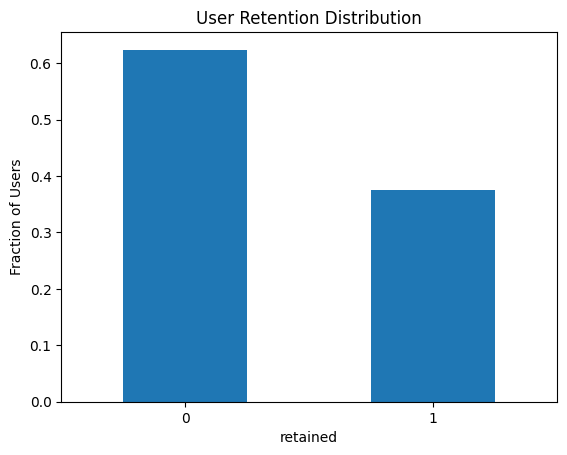

In [26]:
import matplotlib.pyplot as plt

retention_counts = df['retained'].value_counts(normalize=True)

plt.figure()
retention_counts.plot(kind='bar')
plt.title('User Retention Distribution')
plt.ylabel('Fraction of Users')
plt.xticks(rotation=0)
plt.show()

Roughly ~38% of users are retained, indicating moderate class imbalance but not extreme.

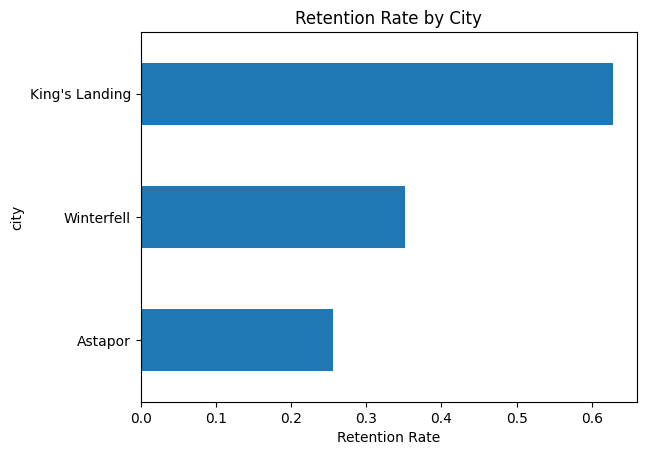

In [27]:
city_retention = df.groupby('city')['retained'].mean().sort_values()

plt.figure()
city_retention.plot(kind='barh')
plt.title('Retention Rate by City')
plt.xlabel('Retention Rate')
plt.show()

King’s Landing has the highest retention.
City is a strong predictor which supports city-specific strategies

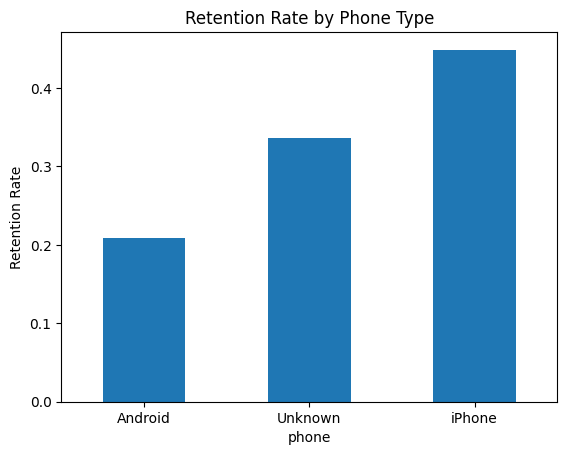

In [29]:
phone_retention = df.groupby('phone')['retained'].mean()

plt.figure()
phone_retention.plot(kind='bar')
plt.title('Retention Rate by Phone Type')
plt.ylabel('Retention Rate')
plt.xticks(rotation=0)
plt.show()

<Figure size 640x480 with 0 Axes>

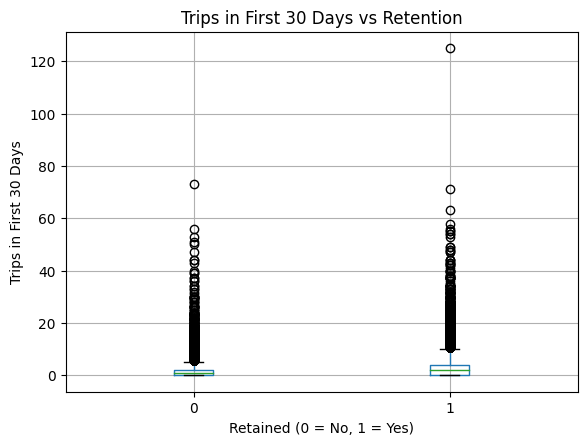

In [30]:
plt.figure()
df.boxplot(
    column='trips_in_first_30_days',
    by='retained'
)
plt.title('Trips in First 30 Days vs Retention')
plt.suptitle('')
plt.xlabel('Retained (0 = No, 1 = Yes)')
plt.ylabel('Trips in First 30 Days')
plt.show()

Early engagement is the strongest retention signal.

<Figure size 640x480 with 0 Axes>

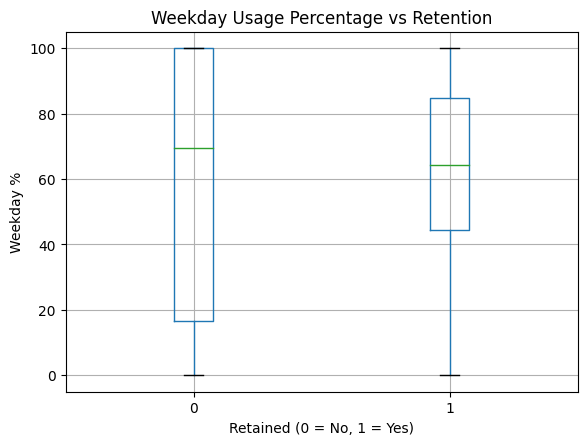

In [32]:
plt.figure()
df.boxplot(
    column='weekday_pct',
    by='retained'
)
plt.title('Weekday Usage Percentage vs Retention')
plt.suptitle('')
plt.xlabel('Retained (0 = No, 1 = Yes)')
plt.ylabel('Weekday %')
plt.show()

Retained users skew toward weekday usage.
This indicates commuter behavior is stickier

<Figure size 640x480 with 0 Axes>

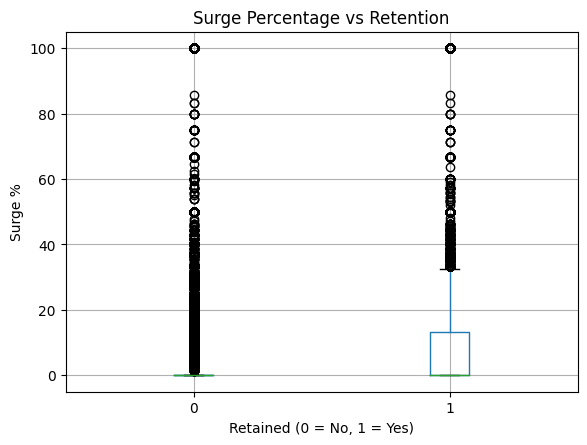

In [34]:
plt.figure()
df.boxplot(
    column='surge_pct',
    by='retained'
)
plt.title('Surge Percentage vs Retention')
plt.suptitle('')
plt.xlabel('Retained (0 = No, 1 = Yes)')
plt.ylabel('Surge %')
plt.show()

Higher surge exposure shows lower retention and Pricing friction impacts churn

## Predictive Model for 6th-Month Activity

In [35]:
features = [
    'avg_dist',
    'avg_rating_by_driver',
    'avg_rating_of_driver',
    'avg_surge',
    'surge_pct',
    'trips_in_first_30_days',
    'weekday_pct',
    'city',
    'phone'
]

X = df[features]
y = df['retained']

In [36]:
X = pd.get_dummies(X, drop_first=True)

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

Models Considered:
    Logistic Regression,
    Random Forest and
    Gradient Boosting.

In [38]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [39]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC-AUC: 0.7344340286128023
              precision    recall  f1-score   support

           0       0.72      0.88      0.79      7799
           1       0.68      0.42      0.52      4701

    accuracy                           0.71     12500
   macro avg       0.70      0.65      0.65     12500
weighted avg       0.70      0.71      0.69     12500



In [40]:
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
}).sort_values(by='coefficient', ascending=False)

coef_df.head(10)

,feature,coefficient
7,city_King's Landing,1.687395
10,phone_iPhone,1.102814
9,phone_Unknown,0.714000
8,city_Winterfell,0.473905
5,trips_in_first_30_days,0.130682
4,surge_pct,0.001585
6,weekday_pct,0.000007
0,avg_dist,-0.033620
2,avg_rating_of_driver,-0.075310
1,avg_rating_by_driver,-0.170660


The analysis shows that early engagement is the strongest predictor of long-term retention, with users who take more trips in their first 30 days far more likely to remain active. Exposure to surge pricing is negatively associated with retention, suggesting that temporary surge protection or pricing incentives for new users could reduce early churn. Retention also varies meaningfully by city and usage patterns, with weekday-focused users retaining at higher rates, indicating an opportunity for commuter-focused and city-specific retention strategies. Overall, these insights suggest that improving the first-month experience and pricing stability would have the greatest impact on long-term rider retention.